In [2]:
import torch
if torch.cuda.is_available:
  device = 'cuda'
else:
  device = 'cpu'

device

'cuda'

In [3]:
class ConvertToRGB():
  def __call__(self, img):
    if img.mode != 'RGB':
      img.convert('RGB')
    return img

In [4]:
from torchvision import transforms
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [5]:
from torchvision import datasets
data_dir = '/content/drive/MyDrive/Images/cat-breeds'
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 2746
    Root location: /content/drive/MyDrive/Images/cat-breeds
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [6]:
print(len(dataset.classes))
dataset.classes

16


['american_curl',
 'bengal',
 'burmese',
 'cymric',
 'egyptian_mau',
 'havana_brown',
 'khao_manee',
 'laperm',
 'mekong_bobtail',
 'ocicat',
 'peterbald',
 'russian_blue',
 'selkirk_rex',
 'singapura',
 'thai',
 'turkish_van']

In [7]:
from torch.utils.data import DataLoader
batch_size = 32
dloader = DataLoader(dataset, batch_size=batch_size)

In [8]:
def mean_std(loader, max_batches=30):
    sum_, sum_sq, count = 0, 0, 0

    for i, (data, _) in enumerate(loader):
        if i == max_batches:
            break
        batch_size, channels, height, width = data.shape
        data = data.view(batch_size, channels, -1)
        sum_ += data.sum(dim=[0, 2])
        sum_sq += (data ** 2).sum(dim=[0, 2])
        count += batch_size * height * width

    mean = sum_ / count
    std = (sum_sq / count - mean ** 2).sqrt()
    return mean, std

mean, std = mean_std(dloader)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [10]:
dataset_norm = datasets.ImageFolder(data_dir, transform=transform_norm)

In [11]:
print(dataset.class_to_idx)

{'american_curl': 0, 'bengal': 1, 'burmese': 2, 'cymric': 3, 'egyptian_mau': 4, 'havana_brown': 5, 'khao_manee': 6, 'laperm': 7, 'mekong_bobtail': 8, 'ocicat': 9, 'peterbald': 10, 'russian_blue': 11, 'selkirk_rex': 12, 'singapura': 13, 'thai': 14, 'turkish_van': 15}


In [60]:
from torch.utils.data import random_split
g = torch.Generator().manual_seed(26)

train, val = random_split(dataset_norm, [.75, .25], generator = g)

In [13]:
from collections import Counter
import pandas as pd
from tqdm.notebook import tqdm
def class_counter(dataset):
    counter = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: counter[idx] for cat, idx in class_to_index.items()})

  0%|          | 0/2060 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Classes in Training Dataset')

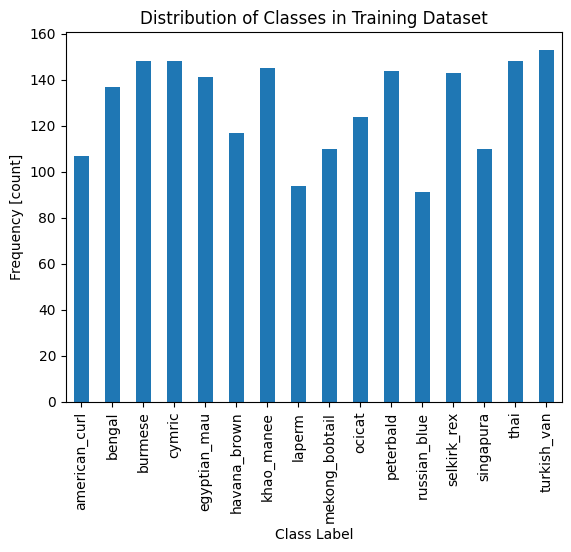

In [61]:
import matplotlib.pyplot as plt
train_dist = class_counter(train)
train_dist.plot(kind='bar')
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset")

  0%|          | 0/686 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Classes in Validation Dataset')

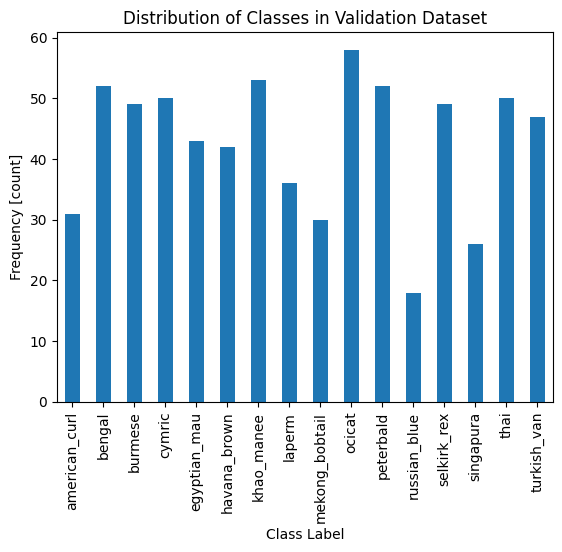

In [57]:
val_dist=class_counter(val)
val_dist.plot(kind='bar')
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset")

In [15]:
train_loader = DataLoader(train, batch_size, generator=g, shuffle=True)
val_loader = DataLoader(val, batch_size, generator=g)

In [16]:
import torchvision.models as models
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 92.8MB/s]


In [17]:
pip install torchinfo

In [18]:
from torchinfo import summary
summary(model, input_size=(32,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [19]:
for params in model.parameters():
    params.requires_grad = False

In [21]:
list(model.named_modules())[-1]

('fc', Linear(in_features=512, out_features=1000, bias=True))

In [26]:
# to modify the network to fit our task
import torch.nn as nn
cbclassifier = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(256, 16)
)
model.fc = cbclassifier

In [27]:
summary(model, input_size=(32,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 16]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]  

In [30]:
from sklearn.model_selection import KFold
k = 5

kfold_splitter = KFold(n_splits=k, shuffle=True, random_state=42)

train_nums, val_nums = next(kfold_splitter.split(range(100)))
fold_fraction = len(val_nums) / (len(train_nums) + len(val_nums))
print(f"One fold is {100*fold_fraction:.2f}%")

One fold is 20.00%


In [35]:
def reset_classifier(model):
    model.fc.get_submodule("0").reset_parameters()
    model.fc.get_submodule("3").reset_parameters()

In [31]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [33]:
tloader = DataLoader(train, batch_size, shuffle=True)
vloader = DataLoader(val, batch_size)

In [44]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    training_loss = 0.0
    model.train()

    # Iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)

def score(model, data_loader, loss_fn, device="cpu"):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    n_observations = data_loader.batch_size * len(data_loader)
    average_loss = total_loss / n_observations
    accuracy = total_correct / n_observations
    return average_loss, accuracy

In [45]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    use_train_accuracy=True,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        # Train one epoch
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        if use_train_accuracy:
            train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        else:
            train_loss = training_loss
            train_accuracy = 0
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"    Training loss: {train_loss:.2f}")
        if use_train_accuracy:
            print(f"    Training accuracy: {train_accuracy:.2f}")
        print(f"    Validation loss: {validation_loss:.2f}")
        print(f"    Validation accuracy: {validation_accuracy:.2f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [46]:
import numpy as np
training_records = {}
fold_count = 0

for train_idx, val_idx in kfold_splitter.split(np.arange(len(dataset))):
    fold_count += 1
    print(f"Fold {fold_count}")

    # Make train and validation data loaders
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Reset the model
    reset_classifier(model)

    # Train
    train_losses, val_losses, train_accuracies, val_accuracies = train(
        model,
        optimizer,
        loss_fn,
        train_loader,
        val_loader,
        epochs=6,
        device=device,
        use_train_accuracy=False,
    )

    # Save training results for graphing
    training_records[fold_count] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

    print("\n\n")

Fold 1


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 2.31
    Validation loss: 1.51
    Validation accuracy: 0.54


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.52
    Validation loss: 1.16
    Validation accuracy: 0.60


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.29
    Validation loss: 1.08
    Validation accuracy: 0.61


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 1.14
    Validation loss: 0.96
    Validation accuracy: 0.63


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 1.06
    Validation loss: 0.99
    Validation accuracy: 0.62


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 1.03
    Validation loss: 0.93
    Validation accuracy: 0.65



Fold 2


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 2.24
    Validation loss: 1.42
    Validation accuracy: 0.54


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.45
    Validation loss: 1.12
    Validation accuracy: 0.62


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.26
    Validation loss: 1.05
    Validation accuracy: 0.65


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 1.14
    Validation loss: 0.94
    Validation accuracy: 0.66


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.99
    Validation loss: 0.88
    Validation accuracy: 0.66


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 1.02
    Validation loss: 0.94
    Validation accuracy: 0.65



Fold 3


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 2.21
    Validation loss: 1.45
    Validation accuracy: 0.53


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.50
    Validation loss: 1.21
    Validation accuracy: 0.56


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.26
    Validation loss: 1.10
    Validation accuracy: 0.61


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 1.12
    Validation loss: 1.07
    Validation accuracy: 0.62


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 1.03
    Validation loss: 1.02
    Validation accuracy: 0.62


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.98
    Validation loss: 1.04
    Validation accuracy: 0.62



Fold 4


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 2.24
    Validation loss: 1.60
    Validation accuracy: 0.45


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.54
    Validation loss: 1.26
    Validation accuracy: 0.58


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.28
    Validation loss: 1.15
    Validation accuracy: 0.60


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 1.12
    Validation loss: 1.07
    Validation accuracy: 0.60


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 1.04
    Validation loss: 1.03
    Validation accuracy: 0.62


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 1.00
    Validation loss: 0.99
    Validation accuracy: 0.62



Fold 5


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 2.22
    Validation loss: 1.33
    Validation accuracy: 0.59


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.50
    Validation loss: 1.15
    Validation accuracy: 0.60


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.27
    Validation loss: 1.03
    Validation accuracy: 0.64


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 1.16
    Validation loss: 0.92
    Validation accuracy: 0.66


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 1.09
    Validation loss: 0.90
    Validation accuracy: 0.64


Training:   0%|          | 0/69 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 1.03
    Validation loss: 0.86
    Validation accuracy: 0.68





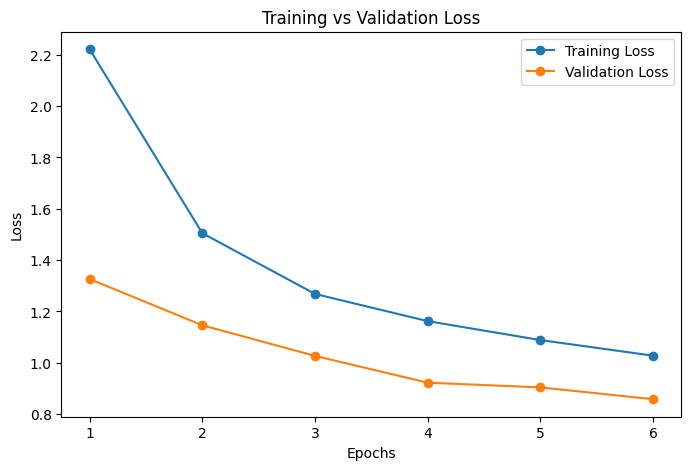

In [53]:
# plotting the losses
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

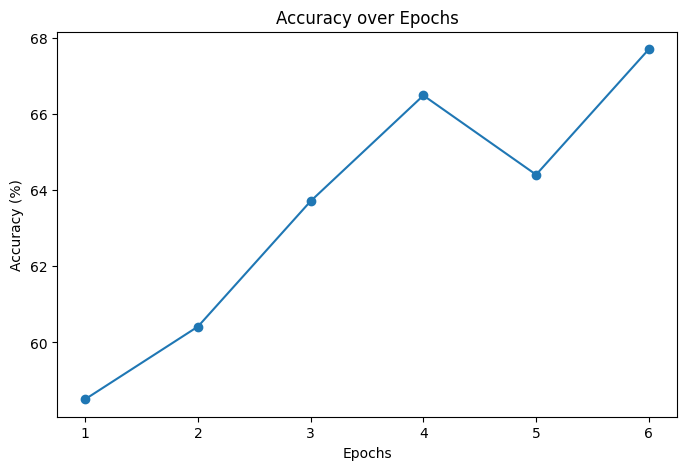

In [55]:
def plot_accuracy(accuracy):
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, [a * 100 for a in accuracy], marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.show()

plot_accuracy(val_accuracies)